In [1]:
%pylab
%matplotlib inline
rc('text', usetex = True)
import os
import os.path as osp
import sklearn
import seaborn
seaborn.set()
figdir = '/Users/brentfollin/Documents/projects/papers/local_hubble/FIGURES/'
rc={
    'axes.labelsize': 12, 
    'font.size': 18, 
    'legend.fontsize': 14.0, 
    'axes.titlesize': 18, 
    'xtick.labelsize': 14, 
    'ytick.labelsize': 14
}
seaborn.set(rc= rc)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import cosmoslik as cs
from cosmoslik.chains import load_chain
from scipy.stats import norm, chi2
import pickle
from numpy import *

In [3]:
def get_data():
    '''
    Grabs the cepheids and sne from the R16 sample
    returns: 
        cepheids: Cepheid dataframe
        sne: sne dataframe
    '''
    filename = '../data/r16_table4.out'
    sne_start = 40
    sne_end = 59
    sne_lines = arange(sne_start,sne_end)
    sne = pd.DataFrame(columns = ['Host', 'sne', 'm^B_0', 'err'], index = arange(sne_end - sne_start))
    ceph_start = 70
    ceph_end = 2346
    cepheid_lines = arange(ceph_start,ceph_end)
    cepheids = pd.DataFrame(columns = ['Field','RA','DEC','ID','Period','VminusI','m_H','sigma_tot','Z'], 
                            index = arange(ceph_end - ceph_start),
                           dtype = 'float')
    f = open(filename)
    for i, line in enumerate(f):
        if i in sne_lines:
            sne.loc[i-sne_start] = line.lower().split()
        if i in cepheid_lines:
            cepheids.loc[i-ceph_start] = line.lower().split()

    f.close()
    cepheids = cepheids.apply(lambda x: pd.to_numeric(x, errors='ignore') );

    sne = sne.apply(lambda x: pd.to_numeric(x, errors='ignore') );


    parallaxes = {'bgcru': (2.23, 0.30,-0.15), 
                  'dtcyg':(2.19,0.33, -0.18), 
                  'ffaql':(2.64,0.16, -0.03),
                  'rtaur':(2.31, 0.19,-0.06),
                  'sscma':(0.348, 0.038, -0.04),
                  'sucas':(2.57,  0.33, -0.13 ),
                  'syaur':(0.428, 0.054, -0.04),
                  'tvul':(2.06,0.22,-0.09 ),
                  'wsgr':(2.30, 0.19, -0.06),
                  'xsgr':(3.17, 0.14, -0.02),
                  'ysgr':(2.13, 0.29, -0.15),
                  'betador':(3.26, 0.14, -0.02),
                  'delceph':(3.71,0.12,-0.01),
                  'etagem':(2.74,0.12,-0.02),
                  'lcar':(2.03,0.16,-0.05)
                 }
    parallaxes = pd.DataFrame.from_dict(parallaxes, orient = 'index', )
    parallaxes.reset_index(inplace=True)
    parallaxes.columns = ['ID', 'parallax', 'p_err', 'LK']
    cepheids = cepheids.merge(parallaxes, on = 'ID', how = 'left')


    cepheids.fillna({'parallax':1e-03, 'p_err':0, 'LK':0}, inplace = True);
    cepheids['err']= sqrt(cepheids.sigma_tot**2 + (cepheids.p_err / cepheids.parallax * 5/log(10))**2)
    return cepheids, sne

In [4]:
cepheids, sne = get_data()
cepheids['logP'] = cepheids.Period.apply(lambda x: log10(x))
cepheids.groupby('Field').count()

,RA,DEC,ID,Period,VminusI,m_H,sigma_tot,Z,parallax,p_err,LK,err,logP
Field,,,,,,,,,,,,,
galaxy,15,15,15,15,15,15,15,15,15,15,15,15,15
lmc,775,775,775,775,775,775,775,775,775,775,775,775,775
m101,251,251,251,251,251,251,251,251,251,251,251,251,251
m31,372,372,372,372,372,372,372,372,372,372,372,372,372
n1015,14,14,14,14,14,14,14,14,14,14,14,14,14
n1309,44,44,44,44,44,44,44,44,44,44,44,44,44
n1365,32,32,32,32,32,32,32,32,32,32,32,32,32
n1448,54,54,54,54,54,54,54,54,54,54,54,54,54
n2442,141,141,141,141,141,141,141,141,141,141,141,141,141


# Figure 1
### BIC criterion as a function of Gaussian Mixture number n

In [5]:
bic_array = np.load('bic_array.npy')
# from sklearn.mixture import GaussianMixture
# features = cepheids[['logP', 'VminusI']]
# bic_array = []
# for n_classes in arange(1,15):
#     model = GaussianMixture(n_components = n_classes, max_iter = 20, n_init = 10, init_params= 'random')
#     estimate = model.fit(features)
#     bic_array += [model.bic(features)]
# scatter(arange(1,15), bic_array)
# xlim(0,16)

In [6]:
#np.save('bic_array.npy', bic_array)

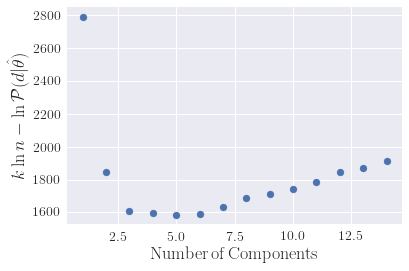

In [7]:

scatter(arange(1,15), bic_array)
ylabel(r'$k \ln n - \ln \mathcal{P}(d|\hat{\theta})$', fontsize = 18)
xlabel(r'${\rm Number\, of\, Components}$', fontsize = 18)
savefig(figdir + 'BICplot.pdf')

# Figure 2

## Plot of the clusters

In [8]:
n_classes = 6
import joblib
with open(osp.join('../data','gaussian_mixture_model'), 'rb') as f:
    model = pickle.load(f, encoding='latin1') #f.close()
seaborn.set_palette('bright')
cmap = seaborn.color_palette()
# cmap = cm.get_cmap('Paired', n_classes)
#cmap.colors
cmap

/usr/local/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.18 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


[(0.0, 0.24705882352941178, 1.0),
 (0.011764705882352941, 0.92941176470588238, 0.22745098039215686),
 (0.90980392156862744, 0.0, 0.043137254901960784),
 (0.54117647058823526, 0.16862745098039217, 0.88627450980392153),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.84313725490196079, 1.0)]

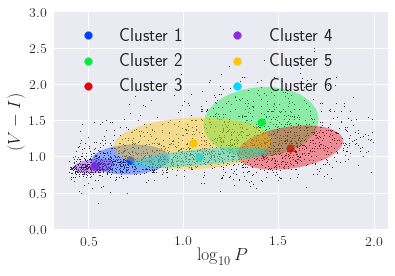

In [9]:
means = model.means_
covariances = model.covariances_

fig = figure()
ax = fig.add_subplot(111)
ax.scatter(cepheids['logP'], cepheids['VminusI'].values, s=1, lw = 0, c = 'k')
ellipses = []
for i, (mu, cov) in enumerate(zip(means, covariances)):
    ax.scatter(mu[0], mu[1], color = cmap[i], s= 60, label = 'Cluster '+ str(i+1))
    v, w = eigh(cov)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    angle = arctan(u[1]/u[0]) * 180/pi
    ell = mpl.patches.Ellipse(mu, v[0], v[1], 180. + angle, color=cmap[i])
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.4)
    ax.add_artist(ell)
    #ellipses += [mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=cmap.colors[i])]

for e in ellipses:
    ax.add_artist(ell)    

xlabel(r'$\log_{10}{P}$',fontsize = 18)
ylabel(r'$(V-I)$', fontsize = 18)
ylim(0, 3)
legend(frameon = False, fontsize = 18, ncol = 2)
savefig(figdir + 'clusters.pdf')

# Figure 3
## Determinations of M_ceph from the 6 populations


In [10]:
multi_pop = load_chain('../data/base_multi_pop.chain').burnin(5000).join()


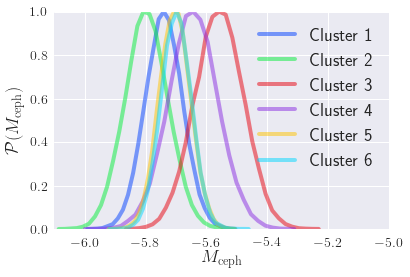

In [16]:
vals = []
multi_pop.like1d('M_ceph0', label = 'Cluster 1', lw = 4, alpha = 0.5, color = cmap[0])
vals += [multi_pop.best_fit()['M_ceph0']]
for pop in arange(1,6):
    multi_pop['Mceph'+str(pop)] = multi_pop['M_ceph0']+multi_pop['M_ceph'+str(pop)]
    vals +=[ multi_pop.best_fit()['Mceph'+str(pop)] ]
    multi_pop.like1d('Mceph'+str(pop), color = cmap[pop], label = 'Cluster '+str(pop+1), lw = 4, alpha = 0.5)
legend(frameon = False, fontsize = 18, ncol = 1);
xlabel(r'$M_{\rm ceph}$', fontsize = 18);
ylabel(r'$\mathcal{P}(M_{\rm ceph})$', fontsize = 18)
ylim(0,1);
xlim(-6.1,-5)
savefig(figdir + 'Mceph_by_cluster.pdf')

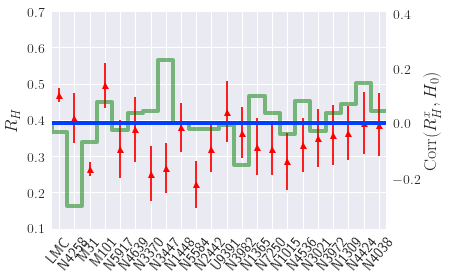

In [17]:
chain = load_chain('../data/varyR_prior_0.1.chain').burnin(5000).join()
ax1 = subplot(111)
xvals = []
xerr = []
fields = []
for field in ['lmc','n4258', 'm31',
                  'm101', 'n5917', 'n4639', 
                  'n3370', 'n3447', 
                  'n1448', 'n5584', 'n2442', 
                  'u9391', 'n3982', 
                  'n1365', 'n7250', 'n1015', 
                  'n4536', 'n3021', 
                  'n3972', 'n1309', 'n4424', 
                  'n4038']:
    xvals += [chain.mean('R_'+field) + 0.39]
    xerr += [chain.std('R_'+field)]
    if field != 'galaxy':
        fields += [field]
    else:
        fields +=['MW']

errorbar(arange(len(xvals)), xvals, yerr = xerr, fmt = '^', color = 'r', label =  r'$+{\rm no\, Pop\, A}$')

#plot(arange(25), ones(25)*sum(array(xvals) * array(xerr)/sum(xerr)), label = r'${\rm mean\, }R_H$')  
#legend( loc = 9, frameon = False)
xticks(arange(len(xvals)), [x.upper() for x in fields], rotation= 50);
#title(r'$R_H_{MW} \, {\rm free}$, \, $H_0 = 70.36 \pm 1.98$')
ylabel(r'$R_H$', fontsize = 18)
ylim(0.1, 0.7)
#fig.subplots_adjust(left = 0.2, bottom = 0.2, top = 0.95, right = 0.95)



ax = twinx(ax1)
fields = ['lmc','n4258', 'm31',
                  'm101', 'n5917', 'n4639', 
                  'n3370', 'n3447', 
                  'n1448', 'n5584', 'n2442', 
                  'u9391', 'n3982', 
                  'n1365', 'n7250', 'n1015', 
                  'n4536', 'n3021', 
                  'n3972', 'n1309', 'n4424', 
                  'n4038']
gridparams = ['H0'] + ['R_'+x for x in fields]
x = arange(len(gridparams))

corr = pd.DataFrame(chain.corr(gridparams), index = gridparams, columns = gridparams)
corr.loc['H0','H0'] = 0


plot(x-0.5,array(corr['H0']), ls = 'steps', lw = 4, c = 'g', alpha = 0.5)
plot(arange(-1, 25), zeros(26) * 0.39, lw = 4)
ax.grid(None)

#xlim(-0.5, len(gridparams)-0.5);
ylim(-0.4+.01, 0.4+.01)
#plot([-1, 30], [0,0], lw = 4)
#ylabel(r'$\frac{\langle H_0 R_{H}^x\rangle}{\sqrt{\langle H_0^2\rangle \langle (R_H^x)^2 \rangle}}$', fontsize = 18)
ylabel(r'${\rm Corr}(R_H^x, H_0)$', fontsize = 18)
xlim(-0.5, len(fields)-0.5);

savefig(figdir + 'R_vs_field.pdf')

In [18]:
burnins = 5000
base = load_chain('../data/base.chain').burnin(burnins).join()
multi_pop = load_chain('../data/base_multi_pop.chain').burnin(burnins).join()
both = load_chain('../data/varyR_manypops.chain').burnin(burnins).join()
varyR = load_chain('../data/varyR.chain').burnin(burnins).join()

In [19]:
def like1d(data, weights, bins = 100):
    
    H, xe = histogram(data,bins,weights=weights,normed=False)
    xem = movavg(xe,2)
    fitdata = [[d]*int(w) for d,w in zip(data, weights)]
    fitdata = [item for sublist in fitdata for item in sublist]
    mu, sigma = norm.fit(fitdata)
    maxval = max(norm.pdf(linspace(min(data), max(data), 10000), scale = sigma, loc = mu))
    return H, xem, mu, sigma, maxval

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


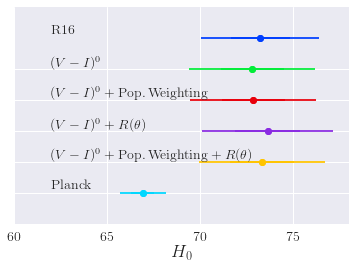

In [20]:
from scipy.stats import norm

H_0 = []
bins = linspace(65,85, 100)
x = linspace(65,82, 10000)
fig, post_fig = subplots()
ylabel(r'$\mathcal{P}(H_0)$', fontsize = 18)
xlabel(r'$H_0$', fontsize= 18)
xlim(60,78)
ylim(0,1)
legend(frameon = False);

box_fig = subplot()
xlim(60,78)
ylim(0,7)
xlabel(r'$H_0$', fontsize = 18)
yticks(arange(6), '')

H0R16 = norm(scale = 1.59, loc = 73.24/1.005)
box_fig.errorbar(73.24, 6, xerr = 2*1.59, fmt = 'o',c = cmap[0])
box_fig.errorbar(73.24, 6, xerr = 1.59, fmt = 'o',c = cmap[0])
box_fig.text(62, 6.1, r'${\rm R}16$', fontsize = 14)


## Base case
xem, H_0, mu, sigma, maxval = like1d(base['H0'], base['weight'])
mu = mu/1.005
H0 = norm(scale = sigma, loc = mu)
box_fig.errorbar(mu, 5, xerr = 2*sigma, fmt = 'o',c = cmap[1])
box_fig.errorbar(mu, 5, xerr = sigma, fmt = 'o',c = cmap[1])


box_fig.text(62, 5.1, r'$(V-I)^0{\rm}$', fontsize = 14)


## many populations
xem, H_0, mu, sigma, maxval = like1d(multi_pop['H0'], multi_pop['weight'])
H0 = norm(scale = sigma, loc = mu)
mu = mu/1.005
box_fig.errorbar(mu, 4, xerr = 2*sigma, fmt = 'o',c = cmap[2])
box_fig.errorbar(mu, 4, xerr = sigma, fmt = 'o',c = cmap[2])


box_fig.text(62, 4.1, r'$(V-I)^0{\rm}+{\rm Pop.\, Weighting}$', fontsize = 14)




## many populations
xem, H_0, mu, sigma, maxval = like1d(varyR['H0'], varyR['weight'])
H0 = norm(scale = sigma, loc = mu)
mu = mu/1.005
box_fig.errorbar(mu, 3, xerr = 2*sigma, fmt = 'o',c = cmap[3])
box_fig.errorbar(mu, 3, xerr = sigma, fmt = 'o',c = cmap[3])
box_fig.text(62, 3.1, r'$(V-I)^0{\rm}+R(\theta)$', fontsize = 14)




## both
xem, H_0, mu, sigma, maxval = like1d(both['H0'], both['weight'])
H0 = norm(scale = sigma, loc = mu)
mu = mu/1.005
box_fig.errorbar(mu, 2, xerr = 2*sigma, fmt = 'o',c = cmap[4])
box_fig.errorbar(mu, 2, xerr = sigma, fmt = 'o',c = cmap[4])

box_fig.text(62, 2.1,r'$(V-I)^0{\rm}+{\rm Pop.\, Weighting} + R(\theta)$', fontsize = 14)



## Planck
sigma = 0.62
mu = 66.93
H0planck = norm(scale = 0.62, loc = 66.93)
box_fig.errorbar(mu, 1, xerr = 2*sigma, fmt = 'o',c = cmap[5], ls = '-.')
box_fig.errorbar(mu, 1, xerr = sigma, fmt = 'o',c = cmap[5])


box_fig.text(62, 1.1, r'$ {\rm Planck}$', fontsize = 14)
savefig(figdir + 'H_0constraints.pdf')

In [21]:
distances = geometric_distances = pd.DataFrame({'lmc' : (18.494, 0.0452),
                                    'n4258' : (29.387, 0.02616*2.17),
                                    'galaxy' : (0,0)
                                    }, 
                                    index = ['mu', 'sigma_mu']
                                   ).T

data = cepheids.join(geometric_distances, on = 'Field')
data['AbsMag'] = data.m_H - data.mu
data = data[data.Field != 'm31']
data = data[['Field','logP', 'Z', 'VminusI', 'AbsMag']]
training = data[data.AbsMag.notnull()]
predict = data[data.AbsMag.isnull()].drop(['AbsMag'], axis = 1)
X_train = training.drop(['AbsMag', 'Field'], axis = 1)
X_pred = predict.drop(['Field'], axis = 1)
Y_train = training['AbsMag']

In [22]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train, Y_train)
AbsMaghat = model.predict(X_pred)

In [23]:
predict['AbsMag'] = AbsMaghat
predict['mu'] = cepheids['m_H'] - predict['AbsMag'] 
predict = predict[predict.AbsMag < 0]

In [24]:
from numpy.random import normal
distances = pd.read_csv('../data/distance_modula.csv', header = None, usecols= [0,4,5], names=['Field','mu','e_mu'])
distances['Field'] = distances['Field'].apply(lambda x: x.lower())
distances = distances.join(cepheids.groupby('Field').count()['RA'], on = 'Field')
distances['e_mu'] = distances['e_mu'] * distances.RA.apply(sqrt)
df = []
for i in distances.index:
    mean = distances.T[i]['mu']
    sigma = distances.T[i]['e_mu']
    mu = normal(loc = mean, scale = sigma, size = 5000)
    mu = clip(mu, mean - 2.5*sigma, mean + 2.5*sigma)
    field = [distances.T[i]['Field']] * mu.size

    df += [pd.DataFrame({'Field':field, 'mu':mu})]
out = pd.concat(df)
#out = out.set_index('Field')

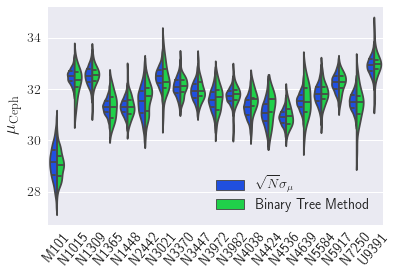

In [25]:
out['CART'] = '$\sqrt{N}\sigma_{\mu}$'
predict['CART'] = 'Binary Tree Method'
df1 = out[['Field', 'mu','CART']]
df2 = predict[['Field', 'mu', 'CART']]
df = pd.concat([df1, df2])
df['Field'] = df.Field.apply(lambda x: x.upper())
seaborn.violinplot(x = 'Field', y = 'mu', hue = 'CART', data = df, split = True, legend = None, scale = 'width', inner = 'quartiles')
legend(loc = 4)
xticks(rotation = 50)
xlabel('', fontsize = 18)
ylabel(r'$\mu_{\rm Ceph}$', fontsize = 18)
savefig(figdir + 'CART_violin.pdf')

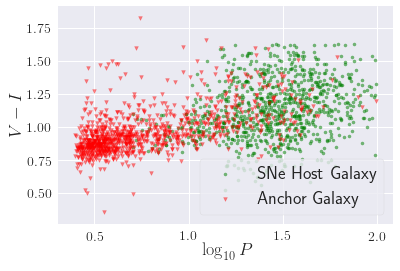

In [26]:
scatter(predict['logP'], predict['VminusI'], color = 'g', s = 10, label = 'SNe Host Galaxy', alpha = 0.5)
scatter(training['logP'], training['VminusI'], color = 'r', s = 15, marker = 'v', label = 'Anchor Galaxy', alpha = 0.5)
xlabel(r'$\log_{10} P$', fontsize = 18)
ylabel(r'$V-I$', fontsize = 18)
legend(loc = 4, frameon = True, fontsize = 18)
savefig(figdir+'tranvtest.pdf')

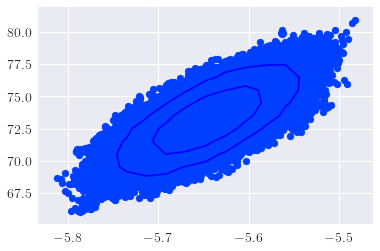

In [27]:
base.like2d('M_ceph0', 'H0')
scatter(base['M_ceph0'], base['H0'])

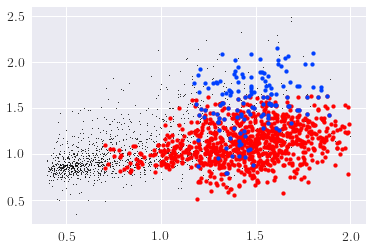

In [29]:
n3447 = cepheids[cepheids.Field == 'n2442']
scatter(cepheids['logP'], cepheids['VminusI'],color = 'k', s = 1, lw = 0)
scatter(predict['logP'], predict['VminusI'],color = 'r',s = 15)
scatter(n3447['logP'], n3447['VminusI'], s = 15)

In [23]:
cepheids.groupby('Field').count()

,RA,DEC,ID,Period,VminusI,m_H,sigma_tot,Z,parallax,p_err,LK,err,logP
Field,,,,,,,,,,,,,
galaxy,15,15,15,15,15,15,15,15,15,15,15,15,15
lmc,775,775,775,775,775,775,775,775,775,775,775,775,775
m101,251,251,251,251,251,251,251,251,251,251,251,251,251
m31,372,372,372,372,372,372,372,372,372,372,372,372,372
n1015,14,14,14,14,14,14,14,14,14,14,14,14,14
n1309,44,44,44,44,44,44,44,44,44,44,44,44,44
n1365,32,32,32,32,32,32,32,32,32,32,32,32,32
n1448,54,54,54,54,54,54,54,54,54,54,54,54,54
n2442,141,141,141,141,141,141,141,141,141,141,141,141,141


In [24]:
cepheids[cepheids.Field == 'n2442'].shape

(141, 14)

In [25]:
cepheids.groupby('Field').mean()

,RA,DEC,Period,VminusI,m_H,sigma_tot,Z,parallax,p_err,LK,err,logP
Field,,,,,,,,,,,,
galaxy,0.000000,0.000000,8.498733,1.016000,3.720667,0.215267,8.900000,2.2744,0.185467,-0.07,0.291959,0.826805
lmc,0.000000,0.000000,6.664063,0.935548,13.895794,0.092094,8.650000,0.0010,0.000000,0.00,0.092094,0.704068
m101,210.806733,54.344430,17.713450,1.091673,22.921514,0.302084,9.142665,0.0010,0.000000,0.00,0.302084,1.190467
m31,11.246881,41.669653,11.588368,1.250054,19.071102,0.147000,8.900000,0.0010,0.000000,0.00,0.147000,0.968408
n1015,39.548892,-1.318359,59.852143,1.307143,24.610000,0.320929,8.772214,0.0010,0.000000,0.00,0.320929,1.750737
n1309,50.526660,-15.401720,55.290227,1.211818,24.625227,0.353545,8.860273,0.0010,0.000000,0.00,0.353545,1.728978
n1365,53.441048,-36.157479,33.648750,1.075000,24.197187,0.324219,8.762750,0.0010,0.000000,0.00,0.324219,1.495285
n1448,56.167511,-44.614309,30.912407,1.013148,24.276481,0.301963,8.796500,0.0010,0.000000,0.00,0.301963,1.445080
n2442,114.069427,-69.554668,32.553546,1.574326,24.590922,0.519184,8.935986,0.0010,0.000000,0.00,0.519184,1.479506


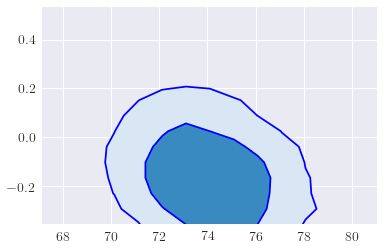

In [26]:
varyR.like2d('H0' ,'R_n4258')

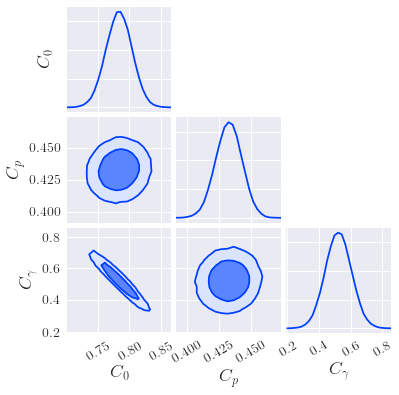

In [27]:
# base.like1d('C00', label = r'$C_0$', lw = 4)
# base.like1d('CP0', label = r'$C_p$', lw = 4)
# base.like1d('CZ0', label = r'$C_\gamma$', lw = 4)
base['CZ0']= - base['CZ0']
params = ['C00','CP0', 'CZ0']
names = [r'$C_0$', r'$C_p$', r'$C_\gamma$']
base.likegrid(color = cmap[0], params = params, param_name_mapping = dict(zip(params, names)), param_label_size = 18)
subplots_adjust(left = 0.15)
#varyR.likegrid(color = cmap[1], params = params, param_name_mapping = dict(zip(params, names)), param_label_size = 18, labels = [r'$(V-I)^0$', r'$(V-I)^0 + R(\theta)$'])
#legend()
savefig(figdir + 'color_constraints.pdf')
# box_fig = subplot(111)
# xem, H_0, mu, sigma, maxval = like1d(base['C00'], base['weight'])
# H0 = norm(scale = sigma, loc = mu)
# box_fig.errorbar(mu, 3, xerr = 2*sigma, fmt = 'o',c = cmap(1), lw = 4)
# box_fig.errorbar(mu, 3, xerr = sigma, fmt = 'o',c = cmap(1), lw = 4)


# box_fig = subplot(111)
# xem, H_0, mu, sigma, maxval = like1d(base['CP0'], base['weight'])
# H0 = norm(scale = sigma, loc = mu)
# box_fig.errorbar(mu, 2, xerr = 2*sigma, fmt = 'o',c = cmap(2), lw = 4)
# box_fig.errorbar(mu, 2, xerr = sigma, fmt = 'o',c = cmap(2), lw = 4)

# box_fig = subplot(111)
# xem, H_0, mu, sigma, maxval = like1d(base['CZ0'], base['weight'])
# H0 = norm(scale = sigma, loc = mu)
# box_fig.errorbar(mu, 1, xerr = 2*sigma, fmt = 'o',c = cmap(3), lw = 4)
# box_fig.errorbar(mu, 1, xerr = sigma, fmt = 'o',c = cmap(3), lw = 4)

In [28]:
base.likegrid?

In [29]:
C0, CP, CZ = (base.best_fit()[key] for key in ['C00','CP0', 'CZ0'])

In [30]:
cepheids['VminusI0'] = C0 + (cepheids.logP - 1) * CP - (cepheids['Z'] -8.9) * CZ
cepheids['Extinction'] = cepheids['VminusI'] - cepheids['VminusI0']

In [31]:
df = cepheids.groupby('Field').mean()
df.sort_values('Extinction')

,RA,DEC,Period,VminusI,m_H,sigma_tot,Z,parallax,p_err,LK,err,logP,VminusI0,Extinction
Field,,,,,,,,,,,,,,
n3447,163.361386,16.779284,34.598125,1.028125,24.746875,0.278200,8.711988,0.0010,0.000000,0.00,0.278200,1.511539,1.097726,-0.069601
n1448,56.167511,-44.614309,30.912407,1.013148,24.276481,0.301963,8.796500,0.0010,0.000000,0.00,0.301963,1.445080,1.022403,-0.009255
n5917,230.387706,-7.376528,39.832308,1.199231,24.866154,0.392538,8.577000,0.0010,0.000000,0.00,0.392538,1.585545,1.204290,-0.005059
n1365,53.441048,-36.157479,33.648750,1.075000,24.197187,0.324219,8.762750,0.0010,0.000000,0.00,0.324219,1.495285,1.062602,0.012398
n4639,190.718925,13.258670,40.420400,1.009200,23.965200,0.360080,8.974840,0.0010,0.000000,0.00,0.360080,1.582544,0.982203,0.026997
n4536,188.590250,2.186233,36.691515,1.104545,23.765758,0.268000,8.778576,0.0010,0.000000,0.00,0.268000,1.506433,1.058586,0.045960
u9391,218.655258,59.338222,42.205357,1.137143,25.441429,0.340214,8.811000,0.0010,0.000000,0.00,0.340214,1.603066,1.081910,0.055233
n3982,179.116078,55.122109,40.672500,1.143125,24.309375,0.300938,8.790938,0.0010,0.000000,0.00,0.300938,1.583534,1.084693,0.058432
n3370,161.768024,17.275719,42.153492,1.182857,24.641905,0.333333,8.793857,0.0010,0.000000,0.00,0.333333,1.596013,1.088409,0.094448


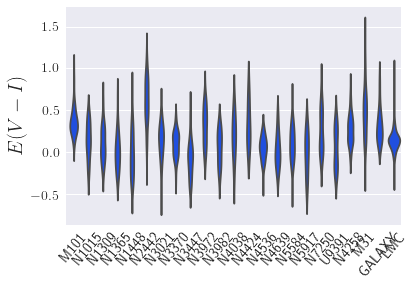

In [32]:
def gal_to_mw(x):
    if (x == 'MILKY WAY'):
        x = 'MW'
    return x.upper()
cepheids['Field'] = cepheids['Field'].apply(gal_to_mw)
seaborn.violinplot(x = 'Field', y = 'Extinction', data = cepheids, inner = None, color = cmap[0])
xticks(rotation = 50)
xlabel('', fontsize = 18)
ylabel(r'$E(V-I)$', fontsize = 18)